In [1]:
import numpy as np
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
from shapely.geometry import Point,Polygon
import shapely

In [2]:
nyc_map = gpd.read_file('/Users/krishna-mac/Desktop/CitadelDataOpen/Map/geo_export_aef695bc-13cc-4e8c-b773-e2fc7ebcae80.shp')

In [3]:
nyc_crime = pd.read_csv('/Users/krishna-mac/Desktop/CitadelDataOpen/Data2/crime1.csv')

In [4]:
nyc_crime = nyc_crime[['CMPLNT_FR_DT','Latitude','Longitude']]
nyc_crime['CMPLNT_FR_DT']= pd.to_datetime(nyc_crime['CMPLNT_FR_DT'], errors='coerce')
nyc_crime.sort_values(by=['CMPLNT_FR_DT'], inplace=True, ascending=False)

In [5]:
start_date = '01-01-2018'
end_date = '12-31-2021'
mask = (nyc_crime['CMPLNT_FR_DT'] >= start_date) & (nyc_crime['CMPLNT_FR_DT'] <= end_date)
nyc_crime = nyc_crime[mask]

In [6]:
geometry = [Point(xy) for xy in zip(nyc_crime['Longitude'],nyc_crime['Latitude'])]
crs = 'EPSG:4326'
geo_df = gpd.GeoDataFrame(nyc_crime, crs = crs, geometry = geometry)
geo_df = geo_df.dropna()

In [7]:
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
ax = gplt.polyplot(boroughs, figsize = (15,15), projection=gcrs.AlbersEqualArea(), zorder=1, color='lightgrey')
gplt.kdeplot(geo_df, cmap='Reds', shade=True, clip=boroughs, ax=ax)

In [8]:
# total area for the grid
xmin, ymin, xmax, ymax= geo_df.total_bounds

# how many cells across and down
n_cells = 100
cell_size = (xmax-xmin)/n_cells

# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

In [9]:
geo_df = geo_df.drop(columns=['CMPLNT_FR_DT','Latitude','Longitude'])
merged = gpd.sjoin(geo_df, cell, how='left', op='within')
merged['n_graf'] = 1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell.loc[dissolve.index, 'n_graf'] = dissolve.n_graf.values

/Users/krishna-mac/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/5r/_x41b2p560v3csbcs3l26vlc0000gn/T/ipykernel_76487/2601474336.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  merged = gpd.sjoin(geo_df, cell, how='left', op='within')


<AxesSubplot:>

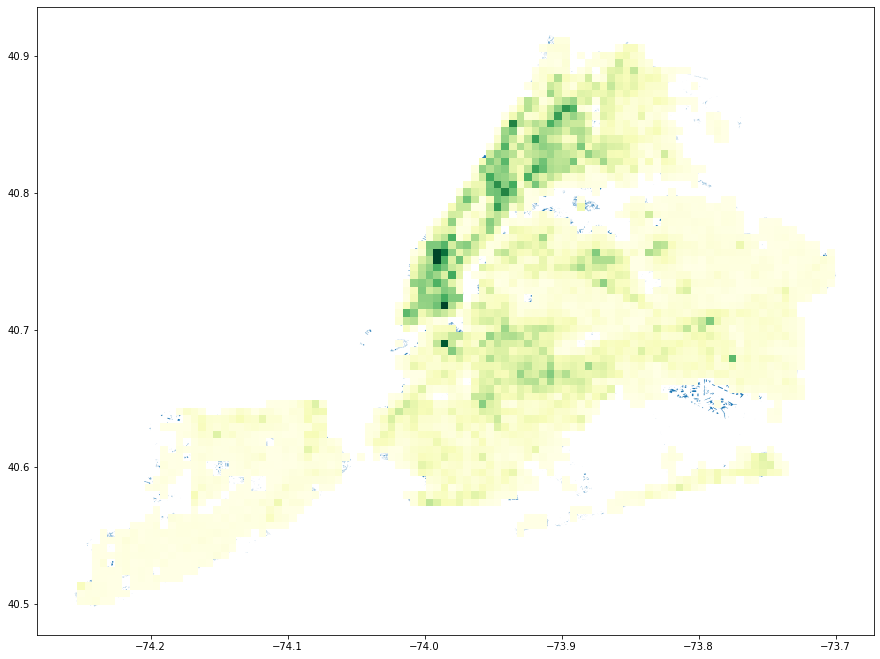

In [10]:
ax = nyc_map.plot(figsize=(15,15))
cell.plot(ax=ax, column='n_graf', cmap='YlGn', vmax=1800)